## Accessing Sentinel-1 RTC data with the Planetary Computer STAC API

The [Sentinel 1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) product in this collection is a radiometrically terrain corrected product derived from the [Sentinel-1 Ground Range Detected (GRD)](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd) Level-1 products produced by the European Space Agency.

### Environment setup

Running this notebook requires an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

See [when an account is needed](https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more, and [request an account](http://planetarycomputer.microsoft.com/account/request) if needed.

In [3]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table
import xarray as xr 
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import pandas as pd
import os
import datetime as dt
from IPython.display import Image

/tmp/ipykernel_378/4208015130.py:10: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_378/4208015130.py:11: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose an area and time of interest

We'll search for assets acquired over Panama in the first week of May, 2022. You can use the [Planetary Computer Explorer](https://planetarycomputer.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [5]:
bbox = [148.146751, -35.660958, 148.156750, -35.650957]
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2016-01-01/2022-06-20"
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 176 items


The `rendered_preview` asset lets us quickly visualize the data. For Seninel-1 RTC, this produces a false-color composite from a combination of the VV and VH bands.

In [6]:
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

The STAC metadata includes many useful pieces of metadata, including metadata from the [SAR](https://github.com/stac-extensions/sar) and [Satellite](https://github.com/stac-extensions/sat) extensions.

In [7]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                                  │
│ datetime                              │ 2022-06-16T19:25:00.622482Z                                 │
│ end_datetime                          │ 2022-06-16 19:25:13.121447+00:00                            │
│ platform                              │ SENTINEL-1A                                                 │
│ proj:bbox                             │ [403750.0, 5885360.0, 692295.0, 6121220.0]                  │
│ proj:epsg                             │ 32755                                                       │
│ proj:shape                            │ [30398, 24129]                                              │
│ proj:transform                        │ [10.0, 0.0, 396840.0, 0.0, -10.0, 6123600.0, 0.0, 0.0, 1.0] │
│ s1:datatake_id                        │ 341855                                                      │
│ s1:instrument_configuration_ID        │ 7                                                           │
│ s1:orbit_source                       │ RESORB                                                      │
│ s1:processing_level                   │ 1                                                           │
│ s1:product_timeliness                 │ Fast-24h                                                    │
│ s1:resolution                         │ high                                                        │
│ s1:shape                              │ [30398, 24129]                                              │
│ s1:slice_number                       │ 12                                                          │
│ s1:total_slices                       │ 16                                                          │
│ sar:center_frequency                  │ 5.405                                                       │
│ sar:frequency_band                    │ C                                                           │
│ sar:instrument_mode                   │ IW                                                          │
│ sar:looks_azimuth                     │ 1                                                           │
│ sar:looks_equivalent_number           │ 4.4                                                         │
│ sar:looks_range                       │ 5                                                           │
│ sar:observation_direction             │ right                                                       │
│ sar:pixel_spacing_azimuth             │ 10                                                          │
│ sar:pixel_spacing_range               │ 10                                                          │
│ sar:polarizations                     │ ['VV', 'VH']                                                │
│ sar:product_type                      │ GRD                                                         │
│ sar:resolution_azimuth                │ 22                                                          │
│ sar:resolution_range                  │ 20                                                          │
│ sat:absolute_orbit                    │ 43692                                                       │
│ sat:orbit_state                       │ descending                                                  │
│ sat:platform_international_designator │ 2014-016A                                                   │
│ sat:relative_orbit                    │ 45                                                          │
│ start_datetime                        │ 2022-06-16 19:24:48.123517+00:00                            │
└───────────────────────────────────────┴───────

The data assets on every Sentinel-1 RTC item will be some combination of `hh`, `hv`, `vh`, and `vv`. These represent the terrain-corrected gamma nought values of a signal transmitted in one polarization ("h" or "v") and received in another ("h" or "v"). The `sar:polarizations` field indicates which assets are available.

In [8]:
item.properties["sar:polarizations"]

['VV', 'VH']

### Visualize the assets

Next, we'll load the `vv` data into [xarray](https://xarray.pydata.org/) and plot the results. We'll use [Dask](http://dask.org/) to load the data in parallel. We're working with a small amount of data so we'll use a single machine. For larger datasets, see [Scaling with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/).

In [9]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

/user/d.neibling@uqconnect.edu.au/proxy/34741/status


/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34741 instead
  warnings.warn(


In [10]:
import stackstac

ds = stackstac.stack(items, bounds_latlon=bbox, epsg=32755, resolution=100)
ds

,Array,Chunk
Bytes,363.00 kiB,1.03 kiB
Shape,"(176, 2, 12, 11)","(1, 1, 12, 11)"
Count,3 Graph Layers,352 Chunks
Type,float64,numpy.ndarray


We'll select the `vv` band for the first timestep found by our search.

In [11]:
vv = ds.sel(band="vv").compute()
vh = ds.sel(band='vh').compute()

The distribution of the raw values is quite skewed:

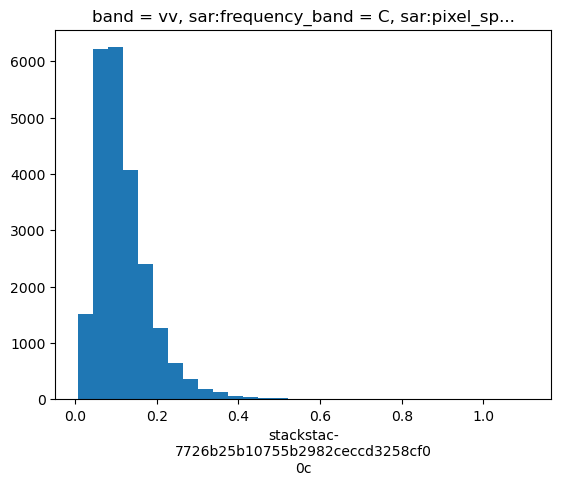

In [12]:
vv.plot.hist(bins=30);

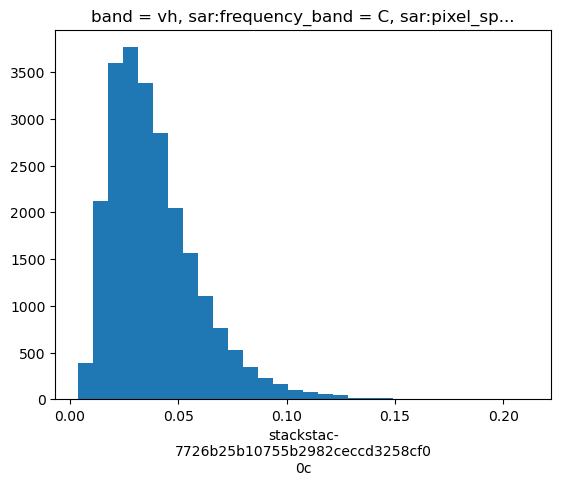

In [13]:
vh.plot.hist(bins=30);

So the values are typically transformed before visualization:

In [19]:
type(vh)

xarray.core.dataarray.DataArray

In [28]:
vh_np = np.asarray(vh)
vh_time_np = np.asarray(vh.time)

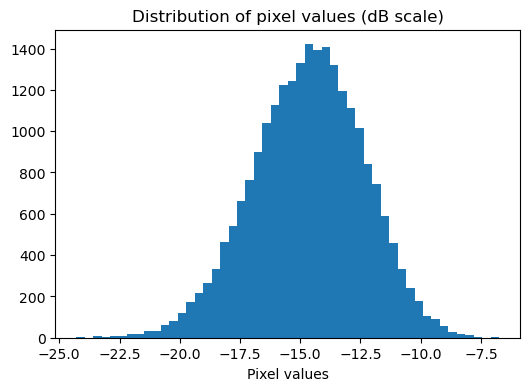

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))


def db_scale(x):
    return 10 * np.log10(x)


db_scale(vh).plot.hist(bins=50, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

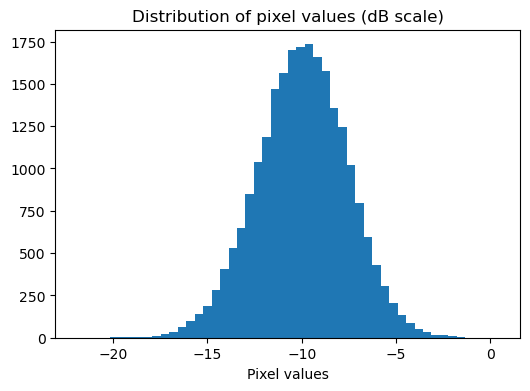

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))


def db_scale(x):
    return 10 * np.log10(x)


db_scale(vv).plot.hist(bins=50, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

In [16]:
#S1_df = pd.read_csv('S1_mean_output.csv')
#vh = S1_df['vh_mean']

In [17]:
vh["vh_dB"] = 10 * np.log10(vh)

In [18]:
vv["vv_dB"] = 10 * np.log10(vv)

# VH SMOOTHING AND PLOTTING

In [17]:
resample_period='2W'
window=4

vh_smooth_std=vh.vh_dB.std(['x', 'y']).resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

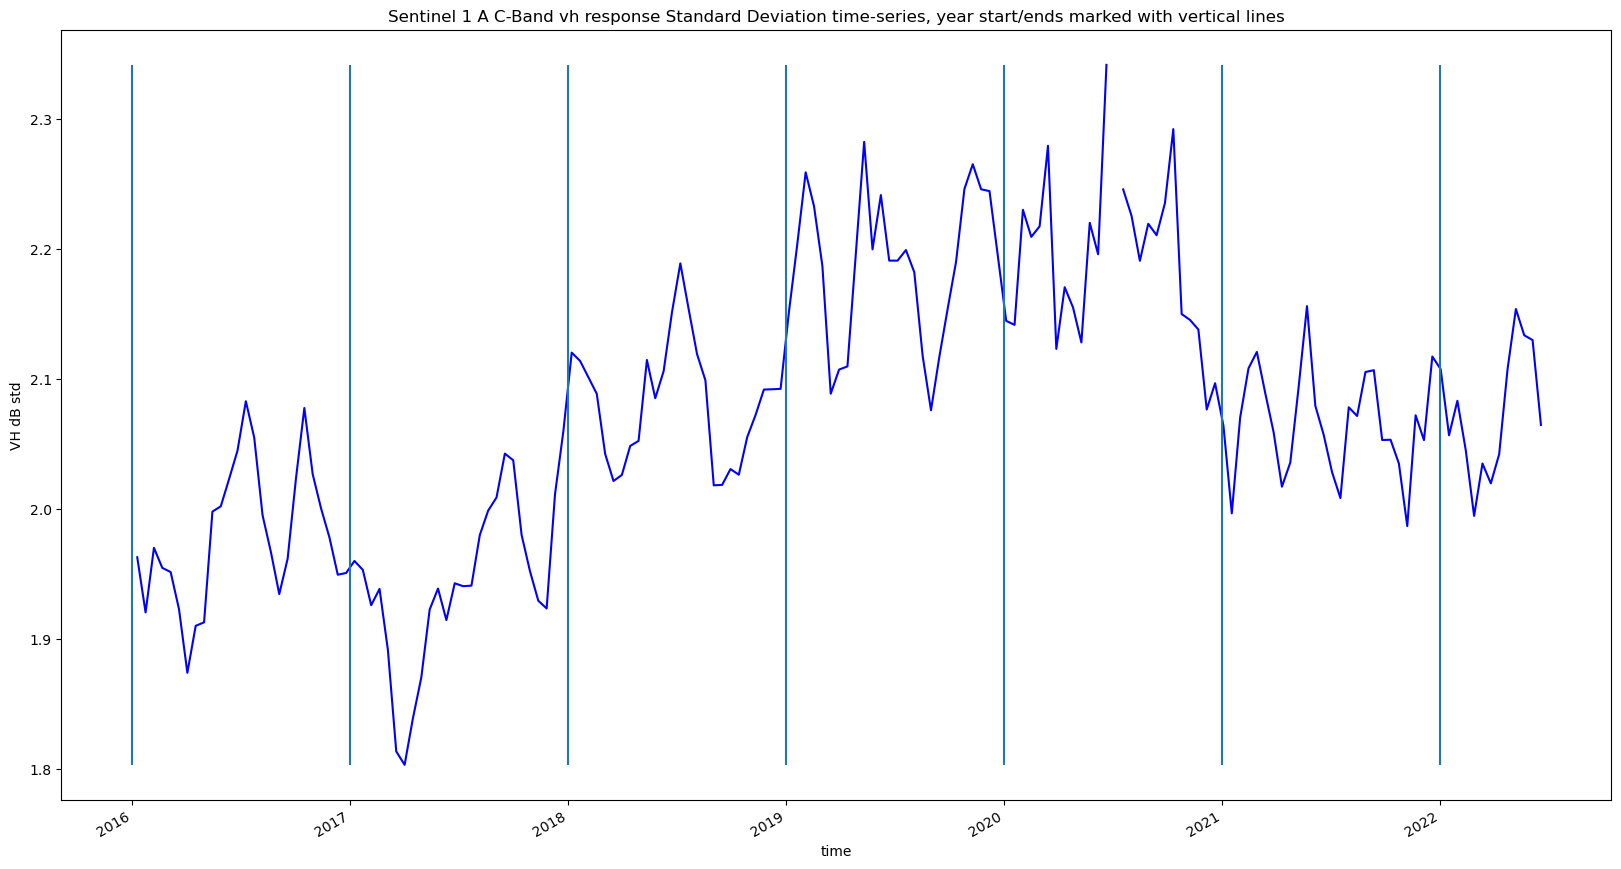

In [18]:
vh_smooth_1D_std = vh_smooth_std
vh_smooth_1D_std.plot.line('b-', figsize=(20,10))
_max=vh_smooth_1D_std.max()
_min=vh_smooth_1D_std.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Sentinel 1 A C-Band vh response Standard Deviation time-series, year start/ends marked with vertical lines')
plt.ylabel('VH dB std');

In [19]:
resample_period='2W'
window=4

vh_smooth=vh.vh_dB.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

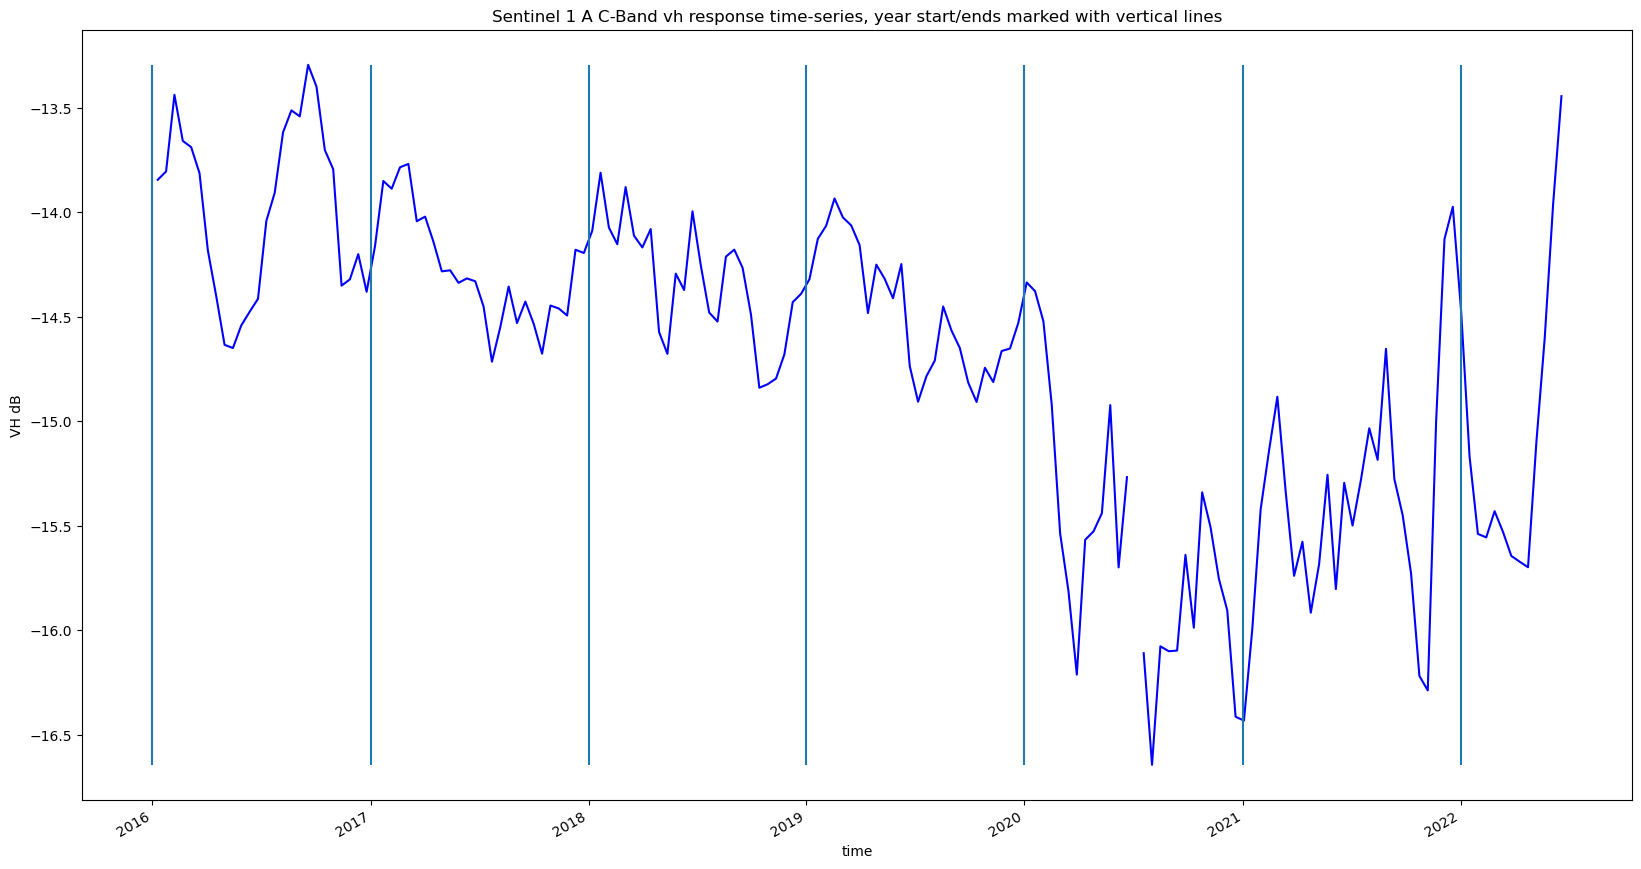

In [20]:
vh_smooth_1D = vh_smooth.mean(['x', 'y'])
vh_smooth_1D.plot.line('b-', figsize=(20,10))
_max=vh_smooth_1D.max()
_min=vh_smooth_1D.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Sentinel 1 A C-Band vh response time-series, year start/ends marked with vertical lines')
plt.ylabel('VH dB');

# VV SMOOTHING AND PLOTTING

In [21]:
resample_period='2W'
window=4

vv_smooth_std=vv.vv_dB.std(['x', 'y']).resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

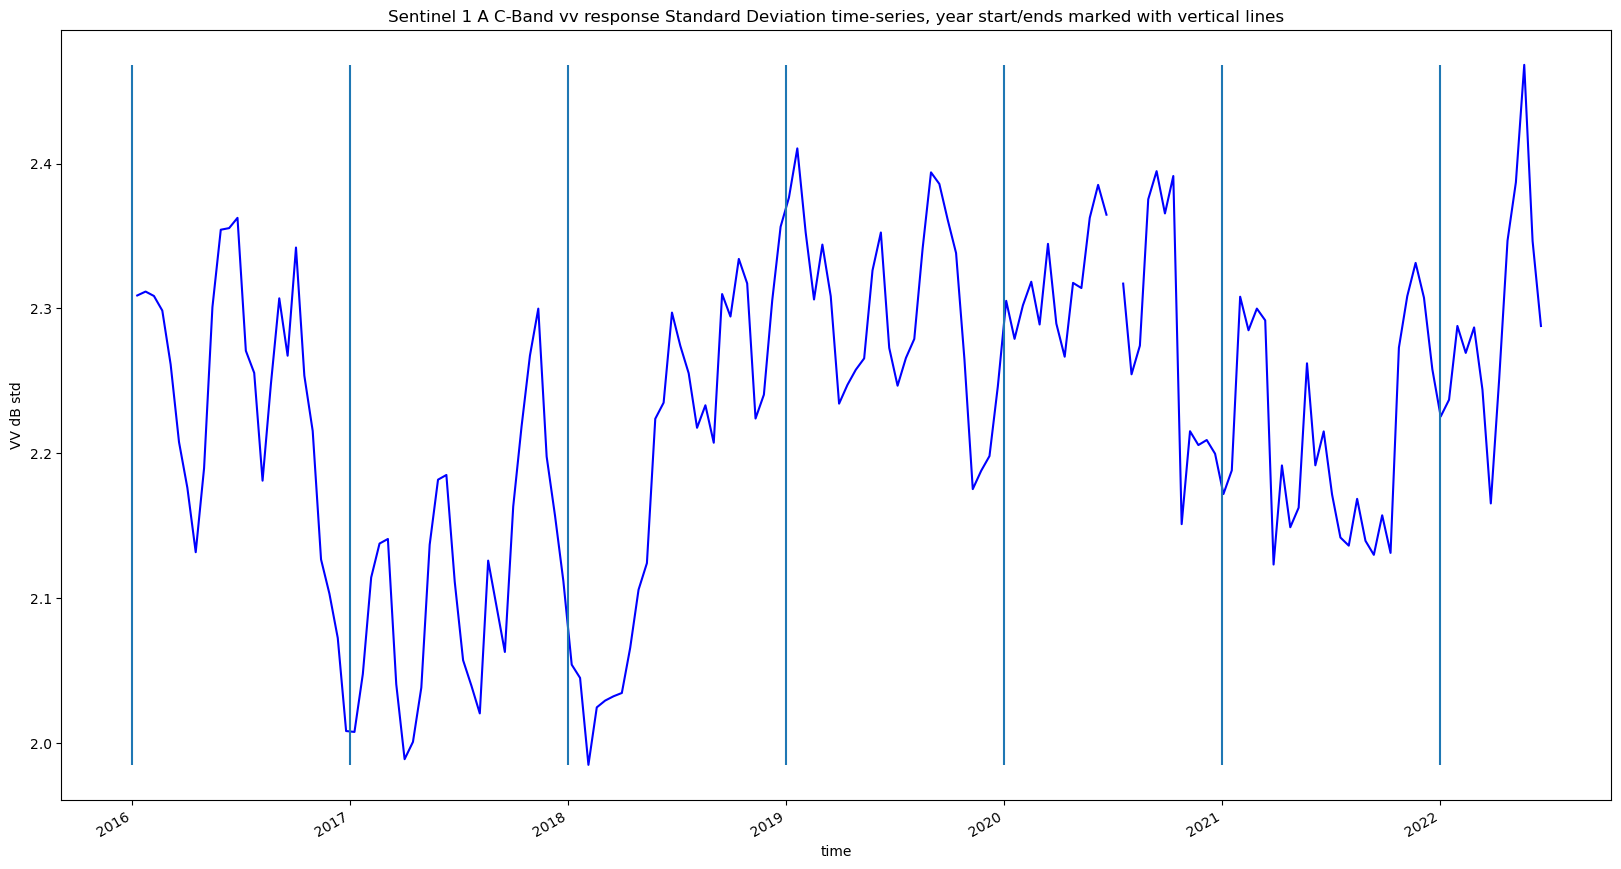

In [22]:
vv_smooth_1D_std = vv_smooth_std
vv_smooth_1D_std.plot.line('b-', figsize=(20,10))
_max=vv_smooth_1D_std.max()
_min=vv_smooth_1D_std.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Sentinel 1 A C-Band vv response Standard Deviation time-series, year start/ends marked with vertical lines')
plt.ylabel('VV dB std');

In [23]:
resample_period='2W'
window=4

vv_smooth=vv.vv_dB.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

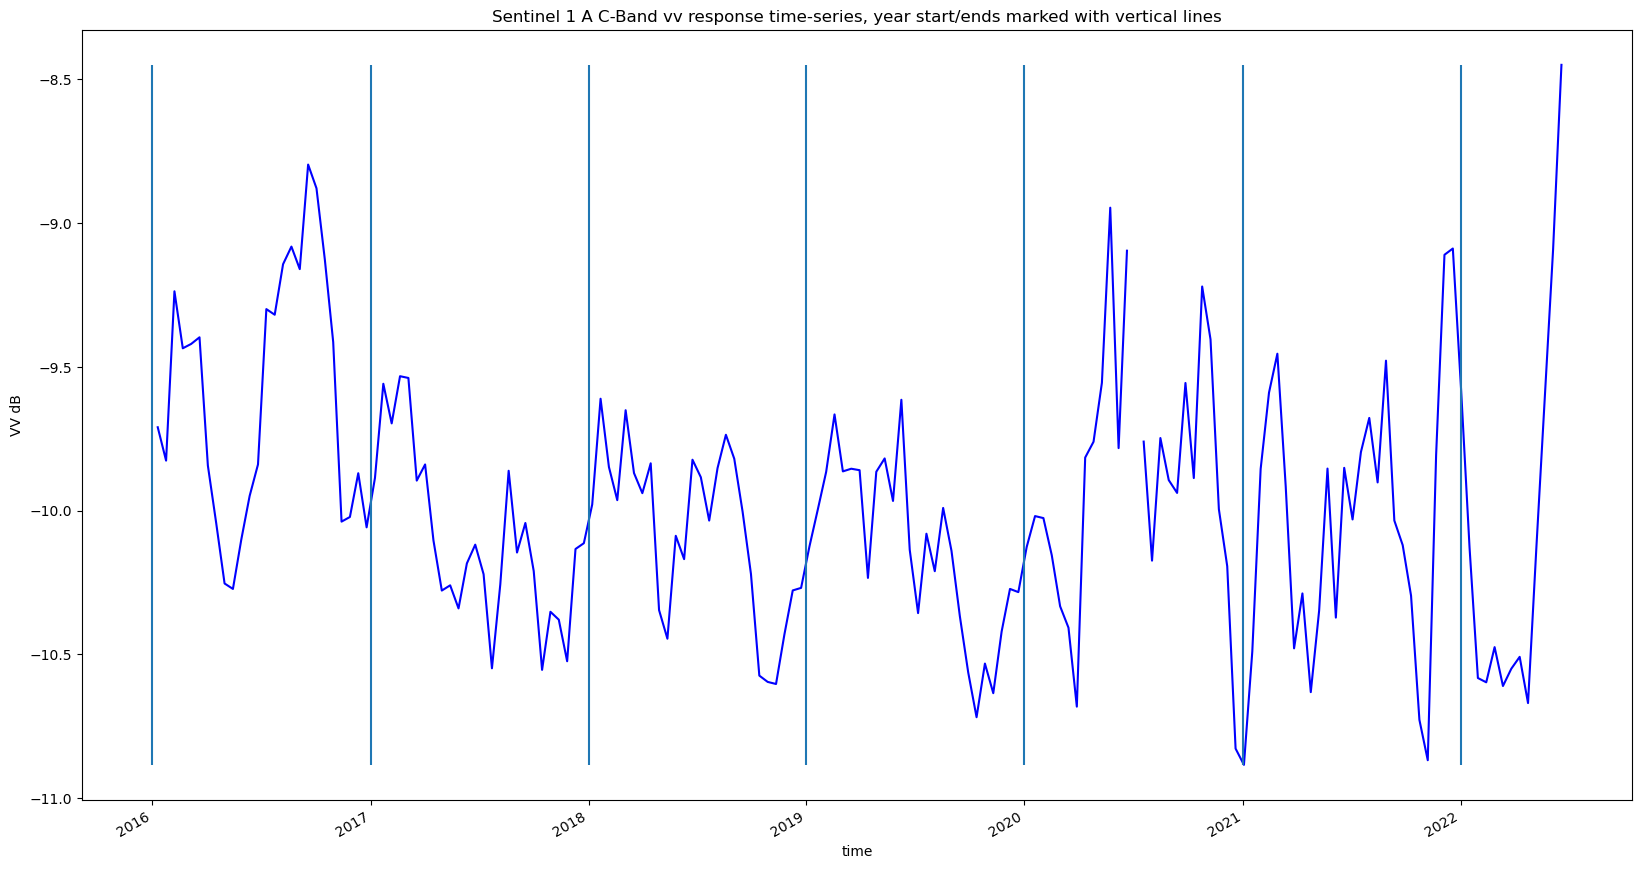

In [24]:
vv_smooth_1D = vv_smooth.mean(['x', 'y'])
vv_smooth_1D.plot.line('b-', figsize=(20,10))
_max=vv_smooth_1D.max()
_min=vv_smooth_1D.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Sentinel 1 A C-Band vv response time-series, year start/ends marked with vertical lines')
plt.ylabel('VV dB');

# Creating VV/VH Ratio

In [25]:
VV_VH_smooth_df = vv_smooth_1D/vh_smooth_1D
VV_VH_smooth_std = vv_smooth_1D_std/vh_smooth_1D_std

In [33]:
Data = vh
Data['vv_vh_dB'] = vv["vv_dB"]/vh["vh_dB"]

In [27]:
import matplotlib.colors
from bokeh.models.tools import BoxZoomTool
import panel
import hvplot.xarray  # noqa

In [36]:
Data.hvplot.kde('vv_vh_dB', by='time.year', alpha = 0.5,cmap='Category7')

:NdOverlay   [time.year]
   :Distribution   [vv_vh_dB]   (Density)

In [37]:
import colorcet as cc
categorical_cmap = [cc.rainbow[int(i)] for i in np.linspace(0, 255, 12)]
Data.hvplot.kde('vv_vh_dB', by='time.month', alpha=0.5,cmap=categorical_cmap)

:NdOverlay   [time.month]
   :Distribution   [vv_vh_dB]   (Density)

In [38]:
Data.hvplot.violin('vv_vh_dB', by='time.month',cmap=categorical_cmap)

:Violin   [time.month]   (vv_vh_dB)

In [39]:
Data.hvplot.violin('vv_vh_dB', by='time.year',cmap=categorical_cmap)

:Violin   [time.year]   (vv_vh_dB)

/tmp/ipykernel_378/1487295487.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_Thumbnail.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_378/1487295487.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_Thumbnail.jpg', dpi=400, facecolor='w', edgecolor='w',


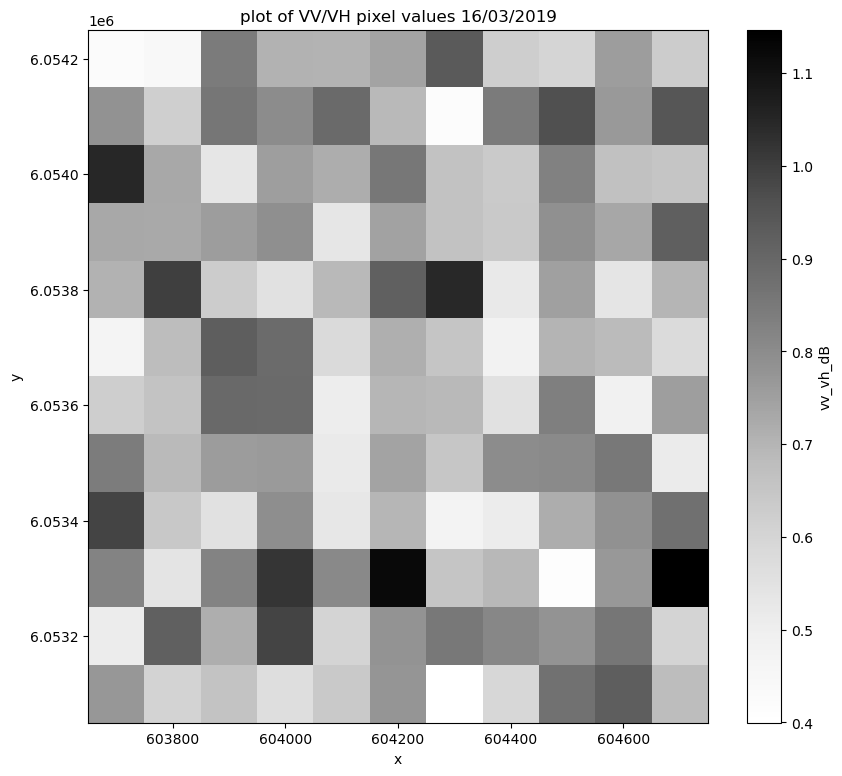

In [41]:
plt.figure(figsize=(10, 9))
Data.vv_vh_dB.sel(time='2019-03-16').plot(cmap='Greys')
plt.title("plot of VV/VH pixel values 16/03/2019")
plt.savefig(fname='S1_VV_VH_Thumbnail.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) ;

In [26]:
#VV_VH_smooth_df = VV_VH_smooth_df.to_dataframe(name = 'VV_VH')

## Exporting smoothed data for further analysis

In [27]:
VV_VH_smooth_df = VV_VH_smooth_df.to_dataframe(name = 'VV_VH')
VV_VH_smooth_df.to_csv('VV_VH_smooth_df.csv', index='time')
#VH_smooth_std = smooth_1D_std.to_dataframe()
#VH_smooth_std.to_csv('VH_smooth_std.csv', index='time')

### VV/VH Ratio Read

In [28]:
#VV_VH_df = pd.read_csv('VV_VH_df.csv', index_col = 2)
#VV_VH_df['time'] = pd.to_datetime(VV_VH_df.index,dayfirst=True)
#VV_VH_df = VV_VH_df.drop(columns = ['index'])

## Graphing results against metrics

### Section 1 - Sandbox Metrics

Loading CSVs of smoothed S2 metrics

In [29]:
EVI_df = pd.read_csv('EVI_smoothed_mean.csv')
EVI_all_df = pd.read_csv('EVI_smoothed_ALL.csv')
Green_df = pd.read_csv('Green_smoothed_mean.csv')
Green_STD_df = pd.read_csv('Green_smoothed_std.csv')
NDVI_df = pd.read_csv('NDVI_smoothed_mean.csv')
NDVI_STD_df = pd.read_csv('NDVI_smoothed_std.csv')
NIR_df = pd.read_csv('NIR_smoothed_mean.csv')
NIR_STD_df = pd.read_csv('NIR_smoothed_std.csv')
SWIR_df = pd.read_csv('SWIR_smoothed_mean.csv')
SWIR_STD_df = pd.read_csv('SWIR_smoothed_std.csv')

## Remove outliers

In [30]:
import scipy.stats as stats
import datetime as dt

In [31]:
EVI_Zscores = stats.zscore(EVI_df['EVI'])
abs_EVI_Zscores = np.abs(EVI_Zscores)
#EVI_filtered = (abs_EVI_Zscores < 3)
EVI_df['EVI_filtered'] = abs_EVI_Zscores
EVI_filtered_df = EVI_df.loc[EVI_df['EVI_filtered'] < 1]
#Green_z_scores
#NDVI_z_scores
#NIR_z_scores
#SWIR_z_scores

In [32]:
time = pd.to_datetime(EVI_df['time'],dayfirst=True)

### EVI Data with S1

Plot: 


/tmp/ipykernel_439/2376658368.py:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_EVI.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/2376658368.py:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_EVI.jpg', dpi=400, facecolor='w', edgecolor='w',


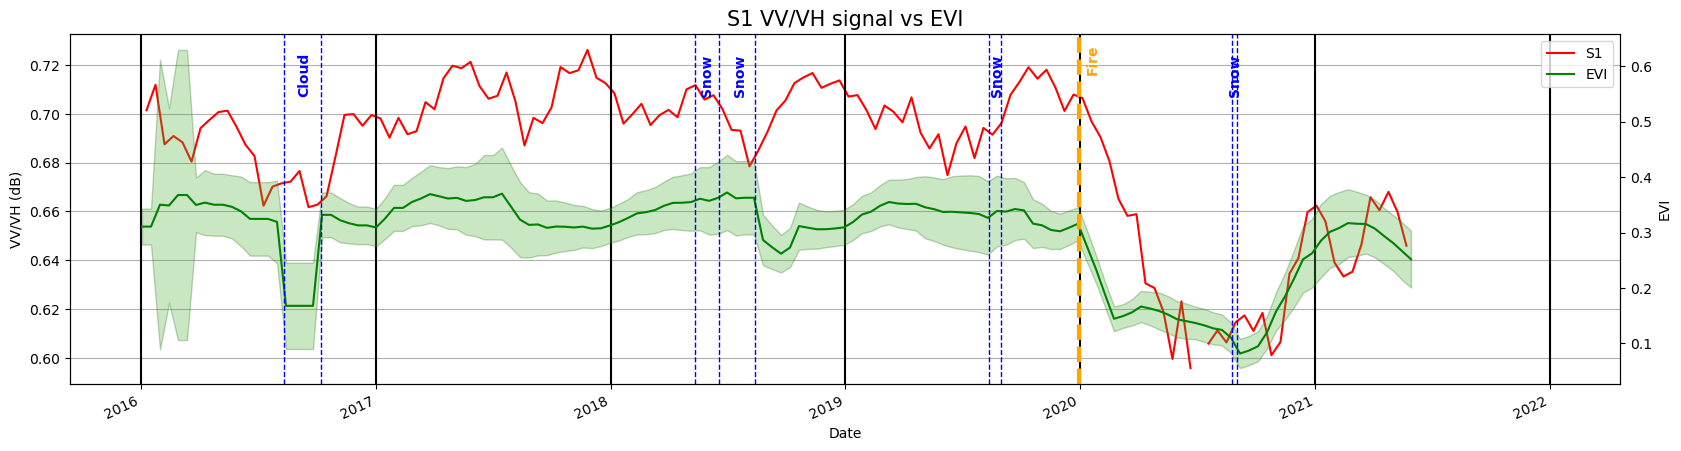

In [49]:
selection = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
selection2 = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
x = selection['time']
x2 = time
y1 = selection
y2 = EVI_df['EVI']
#STD = VV_VH_smooth_std.sel(time = slice('2016-01', '2021-05-30'))
STD2 = EVI_all_df['EVI_STD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = selection.plot(color = 'r', linestyle = 'solid',label = "S1")  
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV/VH (dB)')
plt.title('S1 VV/VH signal vs EVI', fontsize = 15)

# Vertical Year Seperations
plt.axvline(np.datetime64('2016-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2017-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2018-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2019-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2020-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2021-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2022-01-01'),lw=1.5,c='black',ls='-')
plt.grid()


plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "EVI")
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
plt.ylabel('EVI')
plt.legend(handles=[line1,line2])

#Vertical lines
plt.axvline(np.datetime64('2019-12-31'),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2016-08-11'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2016-10-07'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-05-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-06-19'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-31'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-08-25'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-09-01'),lw=1,c='blue',ls='--')


#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.59, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation2 = dt.datetime(2016,9,1)
plt.text(x=x_text_annotation2, y=0.55, s='Cloud', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation3 = dt.datetime(2018,7,10)
plt.text(x=x_text_annotation3, y=0.55, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation4 = dt.datetime(2018,5,20)
plt.text(x=x_text_annotation4, y=0.55, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation5 = dt.datetime(2019,8,14)
plt.text(x=x_text_annotation5, y=0.55, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,8,18)
plt.text(x=x_text_annotation6, y=0.55, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')


plt.savefig(fname='S1_VV_VH_EVI.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) 
plt.show()

## Tasseled Cap Greeness with S1

Plot: 


/tmp/ipykernel_439/2427701840.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_TCG.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/2427701840.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_TCG.jpg', dpi=400, facecolor='w', edgecolor='w',


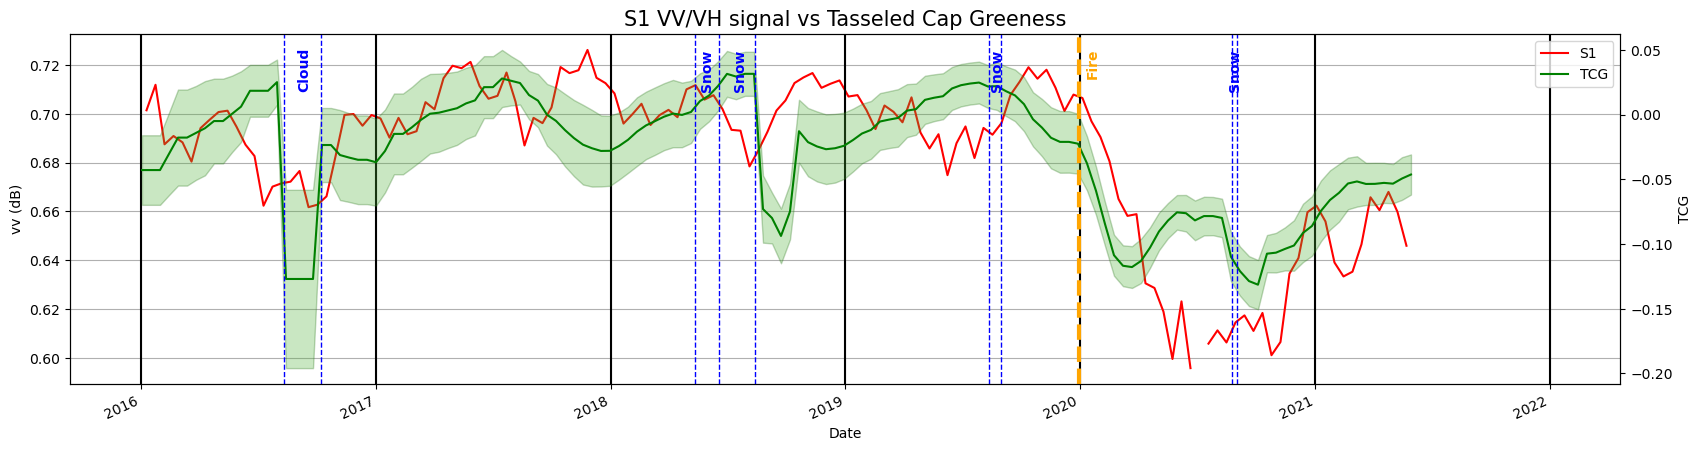

In [50]:
selection = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
x = selection['time']
x2 = time
y1 = selection
y2 = Green_df['Green']
#STD = smooth_1D_std.sel(time = slice('2016-01', '2021-05-30'))
STD2 = Green_STD_df['Green_STD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = selection.plot(color = 'r', linestyle = 'solid',label = "S1")  
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('vv (dB)')
plt.title('S1 VV/VH signal vs Tasseled Cap Greeness', fontsize = 15)

# Vertical Year Seperations
plt.axvline(np.datetime64('2016-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2017-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2018-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2019-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2020-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2021-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2022-01-01'),lw=1.5,c='black',ls='-')
plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "TCG") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('TCG')
plt.legend(handles=[line1,line2])

#Vertical lines
plt.axvline(np.datetime64('2019-12-31'),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2016-08-11'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2016-10-07'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-05-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-06-19'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-31'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-08-25'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-09-01'),lw=1,c='blue',ls='--')


#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.03, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation2 = dt.datetime(2016,9,1)
plt.text(x=x_text_annotation2, y=0.02, s='Cloud', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation3 = dt.datetime(2018,7,10)
plt.text(x=x_text_annotation3, y=0.02, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation4 = dt.datetime(2018,5,20)
plt.text(x=x_text_annotation4, y=0.02, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation5 = dt.datetime(2019,8,14)
plt.text(x=x_text_annotation5, y=0.02, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,8,18)
plt.text(x=x_text_annotation6, y=0.02, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_TCG.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) 
plt.show()

## NDVI with S1

Plot: 


/tmp/ipykernel_439/2712859913.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_NDVI.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/2712859913.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_NDVI.jpg', dpi=400, facecolor='w', edgecolor='w',


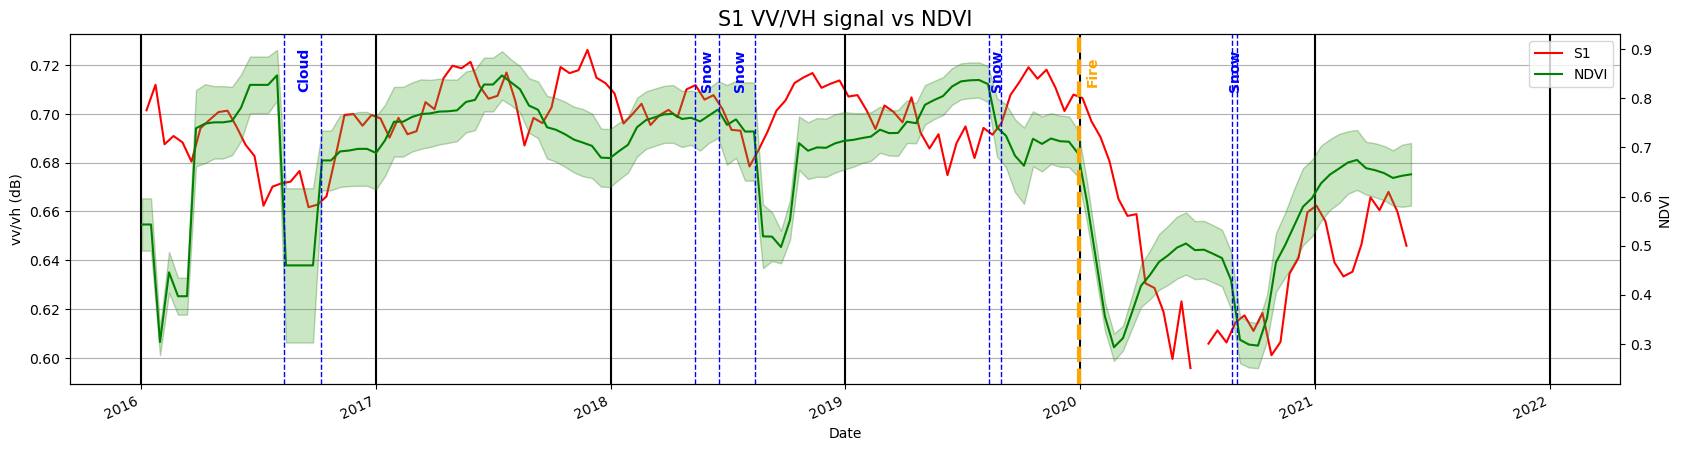

In [51]:
selection = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
x = selection['time']
x2 = time
y1 = selection
y2 = NDVI_df['NDVI']
#STD = smooth_1D_std.sel(time = slice('2016-01', '2021-05-30'))
STD2 = NDVI_STD_df['NDVI_STD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = selection.plot(color = 'r', linestyle = 'solid',label = "S1")  
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('vv/vh (dB)')
plt.title('S1 VV/VH signal vs NDVI', fontsize = 15)

# Vertical Year Seperations
plt.axvline(np.datetime64('2016-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2017-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2018-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2019-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2020-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2021-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2022-01-01'),lw=1.5,c='black',ls='-')
plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "NDVI") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
plt.ylabel('NDVI')
plt.legend(handles=[line1,line2])

#Vertical lines
plt.axvline(np.datetime64('2019-12-31'),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2016-08-11'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2016-10-07'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-05-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-06-19'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-31'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-08-25'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-09-01'),lw=1,c='blue',ls='--')


#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.83, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation2 = dt.datetime(2016,9,1)
plt.text(x=x_text_annotation2, y=0.82, s='Cloud', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation3 = dt.datetime(2018,7,10)
plt.text(x=x_text_annotation3, y=0.82, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation4 = dt.datetime(2018,5,20)
plt.text(x=x_text_annotation4, y=0.82, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation5 = dt.datetime(2019,8,14)
plt.text(x=x_text_annotation5, y=0.82, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,8,18)
plt.text(x=x_text_annotation6, y=0.82, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_NDVI.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) 
plt.show()

## NIR with S1

Plot: 


/tmp/ipykernel_439/2129791869.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_NIR.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/2129791869.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_NIR.jpg', dpi=400, facecolor='w', edgecolor='w',


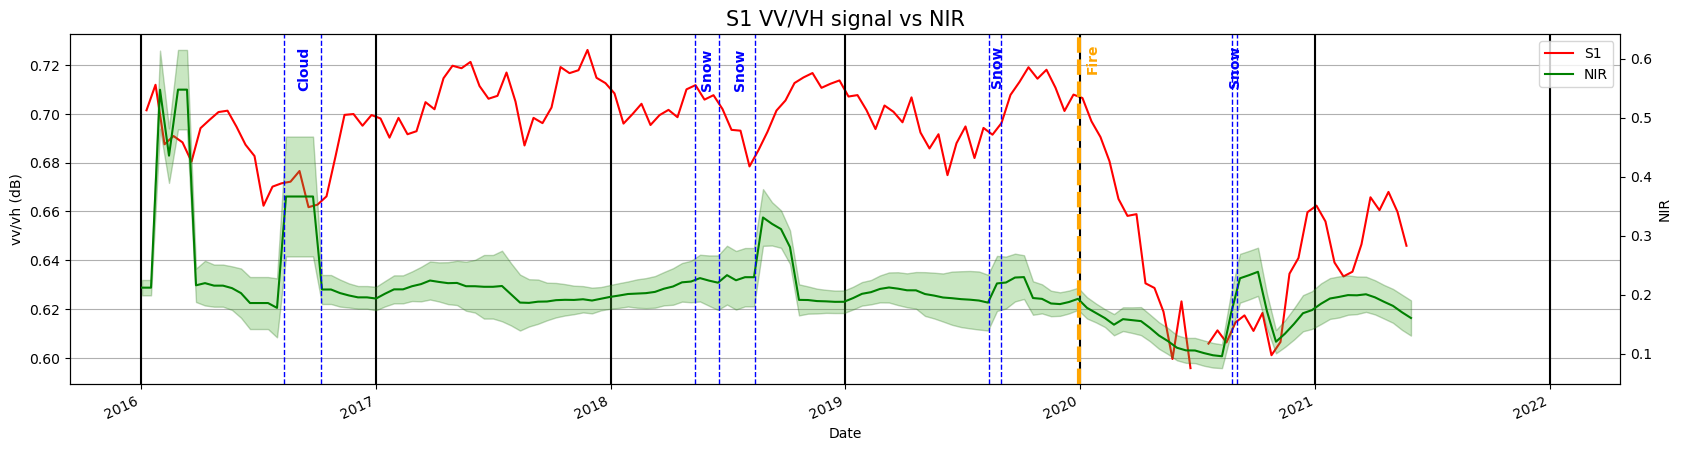

In [53]:
selection = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
x = selection['time']
x2 = time
y1 = selection
y2 = NIR_df['NIR']/10000
#STD = smooth_1D_std.sel(time = slice('2016-01', '2021-05-30'))
STD2 = NIR_STD_df['NIR_STD']/10000

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = selection.plot(color = 'r', linestyle = 'solid',label = "S1")  
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('vv/vh (dB)')
plt.title('S1 VV/VH signal vs NIR', fontsize = 15)

# Vertical Year Seperations
plt.axvline(np.datetime64('2016-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2017-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2018-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2019-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2020-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2021-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2022-01-01'),lw=1.5,c='black',ls='-')
plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "NIR") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('NIR')
plt.legend(handles=[line1,line2])
#Vertical lines
plt.axvline(np.datetime64('2019-12-31'),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2016-08-11'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2016-10-07'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-05-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-06-19'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-31'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-08-25'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-09-01'),lw=1,c='blue',ls='--')


#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.5800, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation2 = dt.datetime(2016,9,1)
plt.text(x=x_text_annotation2, y=0.5500, s='Cloud', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation3 = dt.datetime(2018,7,10)
plt.text(x=x_text_annotation3, y=0.5500, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation4 = dt.datetime(2018,5,20)
plt.text(x=x_text_annotation4, y=0.5500, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation5 = dt.datetime(2019,8,14)
plt.text(x=x_text_annotation5, y=0.5550, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,8,18)
plt.text(x=x_text_annotation6, y=0.5550, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_NIR.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) 
plt.show()

## SWIR with S1

Plot: 


/tmp/ipykernel_439/249898028.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SWIR.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/249898028.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SWIR.jpg', dpi=400, facecolor='w', edgecolor='w',


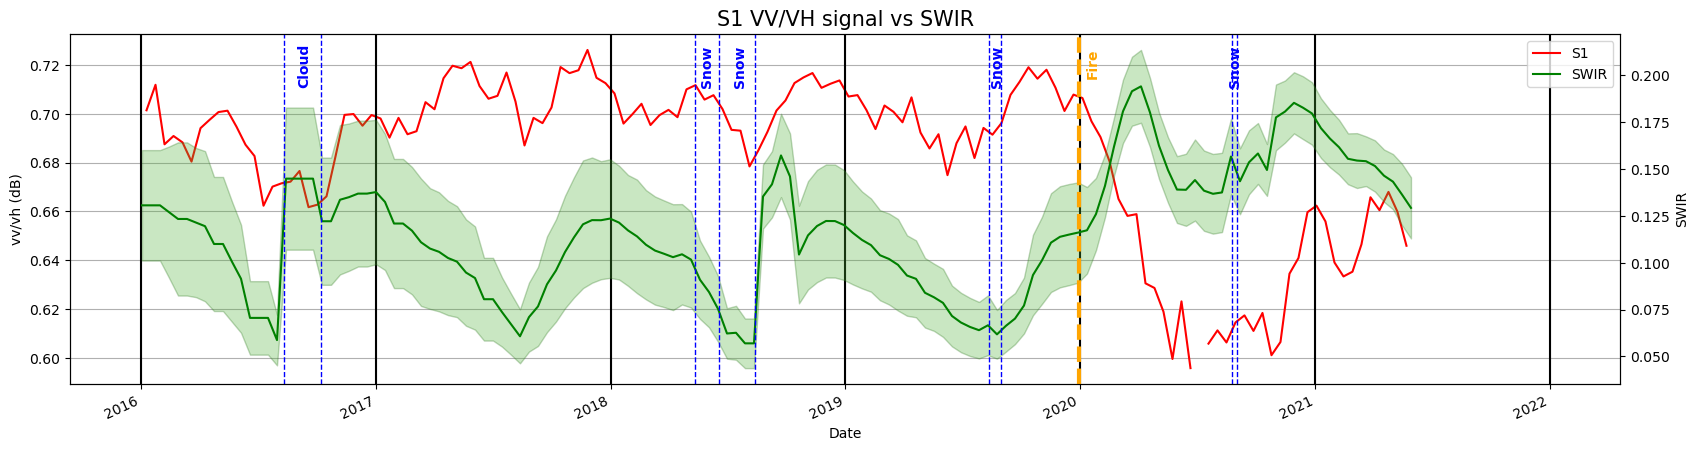

In [54]:
selection = VV_VH_smooth_df.sel(time = slice('2016-01','2021-05-30'))
x = selection['time']
x2 = time
y1 = selection
y2 = SWIR_df['SWIR']/10000
#STD = smooth_1D_std.sel(time = slice('2016-01', '2021-05-30'))
STD2 = SWIR_STD_df['SWIR_STD']/10000

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = selection.plot(color = 'r', linestyle = 'solid',label = "S1")  
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('vv/vh (dB)')
plt.title('S1 VV/VH signal vs SWIR', fontsize = 15)

# Vertical Year Seperations
plt.axvline(np.datetime64('2016-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2017-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2018-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2019-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2020-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2021-01-01'),lw=1.5,c='black',ls='-')
plt.axvline(np.datetime64('2022-01-01'),lw=1.5,c='black',ls='-')
plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "SWIR") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('SWIR')
plt.legend(handles=[line1,line2])
#Vertical lines
plt.axvline(np.datetime64('2019-12-31'),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2016-08-11'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2016-10-07'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-05-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-06-19'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2018-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-13'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2019-08-31'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-08-25'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-09-01'),lw=1,c='blue',ls='--')

#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.2000, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation2 = dt.datetime(2016,9,1)
plt.text(x=x_text_annotation2, y=0.1950, s='Cloud', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation3 = dt.datetime(2018,7,10)
plt.text(x=x_text_annotation3, y=0.1950, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation4 = dt.datetime(2018,5,20)
plt.text(x=x_text_annotation4, y=0.1950, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation5 = dt.datetime(2019,8,14)
plt.text(x=x_text_annotation5, y=0.1950, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,8,18)
plt.text(x=x_text_annotation6, y=0.1950, s='Snow', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_SWIR.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None) 
plt.show()

## Determining Correlation

### Correlation Between TCG and NDVI

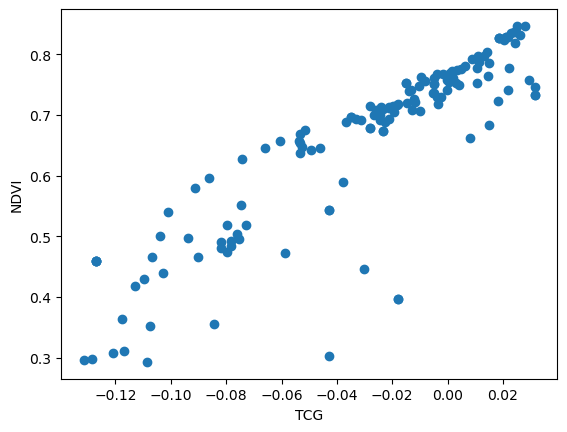

In [31]:
# Plotting the variables as a scatter
TCG = Green_df['Green']
NDVI = NDVI_df['NDVI']
plt.xlabel('TCG')
plt.ylabel('NDVI')
plt.scatter(TCG,NDVI)

It is clear that there is a definite linear trend and thus it is worth measuring the covariance of the data

In [32]:
from scipy.stats import pearsonr
from numpy import cov
# Calculating Covariance Matrix
covariance = cov(TCG, NDVI)
print('covariance matrix:')
print(covariance)

#Calculating Pearsons Correlation
print('')
print('Pearsons correlation:')
pearsonr(TCG, NDVI)

covariance matrix:
[[0.00201237 0.00572139]
 [0.00572139 0.02098588]]

Pearsons correlation:


PearsonRResult(statistic=0.8804093667998146, pvalue=3.303717905894692e-47)

The covariance matrix indicates positive correlation.
The pearsons correlations being 0.88 with a two tailed p-value being less than 0.05 indicates strong correlation between the two metrics.

### Correlation Between Bands B and Band A

first find what timesteps match between B and A, then we can plot those if there are enough..

DATES MATCHING FOUND IN EXCEL
(2016-01-31,2016-04-24,2016-07-17,2016-10-09,2017-01-01,2017-03-26,2017-06-18,
2017-09-10,2017-12-03,2018-02-25,2018-05-20,2018-08-12,2018-11-04,2019-01-27,
2019-04-21,2019-07-14,2019-10-06,2019-12-29,2020-03-22,2020-11-29,2021-02-21,
2021-03-29,2021-05-16)

In [59]:
#Develop a Data Frame of the matching capture dates
time_subset = ['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
               '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
               '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
               '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
               '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
               '2021-02-21','2021-05-16']

time_subset_df = pd.DataFrame(time_subset)
time_subset_df.columns = ['time_subset']
time_subset_df['time_subset'] = pd.to_datetime(time_subset_df['time_subset'])

Appending corrected format 'time' to s2 metrics

In [60]:
EVI_df['time_'] = time
Green_df['time_'] = time
NDVI_df['time_'] = time
NIR_df['time_'] = time
SWIR_df['time_'] = time

In [61]:
#Making VH and VV subsets available for analysis
S1_Subset = pd.read_csv('S1_VV_VH_dB_Alligned_S2.csv')
S1_Subset.rename(columns={"DATES IN ALLIGNMENT":"Time_",},inplace=True)
S1_Subset.index = time_subset

#S1_VVSubset = pd.read_csv('S1_VV_dB_Alligned_S2.csv')
#S1_VVSubset.rename(columns={"DATES IN ALLIGNMENT":"Time_",},inplace=True)
#S1_VVSubset.index = time_subset

N 2016,8,11
Y 2016,10,7
N 2018,5,13
N 2018,6,19
N 2018,7,22
Y 2018,8,13
N 2018,9,30
N 2019,8,13
N 2019,9,12

***OLD TIMES***
EVI_subset = EVI_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]

In [62]:
#Gathering subset of matching dates between S1(A) and S2(B)
NDVI_subset = NDVI_df[NDVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
EVI_subset = EVI_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
Green_subset = Green_df[Green_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
NIR_subset = NIR_df[NIR_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
SWIR_subset = SWIR_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]

In [63]:
#Creating a DataFrame for a covariance matrix between S2 B band Indices

cov_s = NDVI_df['NDVI'] # 1 Creating a string of NDVI
cov_df = pd.DataFrame(cov_s) # 2 Converting to DataFrame

# 3 Joining subsets to DataFrame
TCG = Green_df['Green']
cov_df = cov_df.join(TCG)
NIR = NIR_df['NIR']/10000
cov_df = cov_df.join(NIR)
SWIR = SWIR_df['SWIR']/10000
cov_df = cov_df.join(SWIR)
EVI = EVI_df['EVI']
cov_df = cov_df.join(EVI)

## Plotting Covariance Scatterplots B Bands

/tmp/ipykernel_439/3713007242.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/3713007242.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',


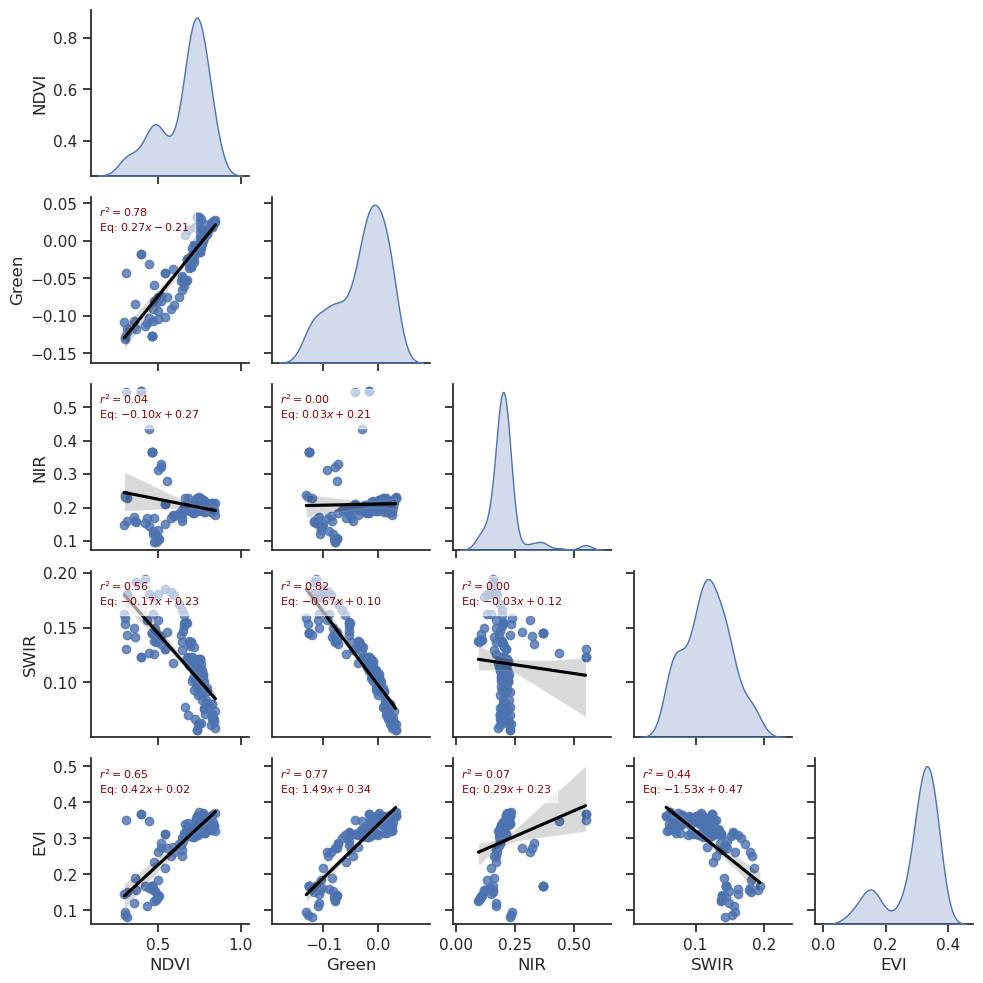

In [64]:
import seaborn as sns
from scipy.stats import linregress

def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')
    
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(cov_df, kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
plt.savefig(fname='S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

In [65]:
#Creating a DataFrame for a covariance matrix between S1 and S2 Indices

S1cov_s = NDVI_subset['NDVI'] # 1 Creating a string of NDVI
S1cov_df = pd.DataFrame(S1cov_s) # 2 Converting to DataFrame

# 3 Joining subsets to DataFrame
TCG = Green_subset['Green']
S1cov_df = S1cov_df.join(TCG)
NIR = NIR_subset['NIR']/10000
S1cov_df = S1cov_df.join(NIR)
SWIR = SWIR_subset['SWIR']/10000
S1cov_df = S1cov_df.join(SWIR)
EVI = EVI_subset['EVI']
S1cov_df = S1cov_df.join(EVI)
S1cov_df.index = time_subset # 4 Assigning time as the index for the subset data
S1 = S1_Subset['VV_VH_dB']
S1cov_df = S1cov_df.join(S1)
#S1 = S1_VVSubset['VV_dB']
#S1cov_df = S1cov_df.join(S1)

## Plotting covariance scatterplots for A and B band Subsets

/tmp/ipykernel_439/3760706757.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_439/3760706757.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',


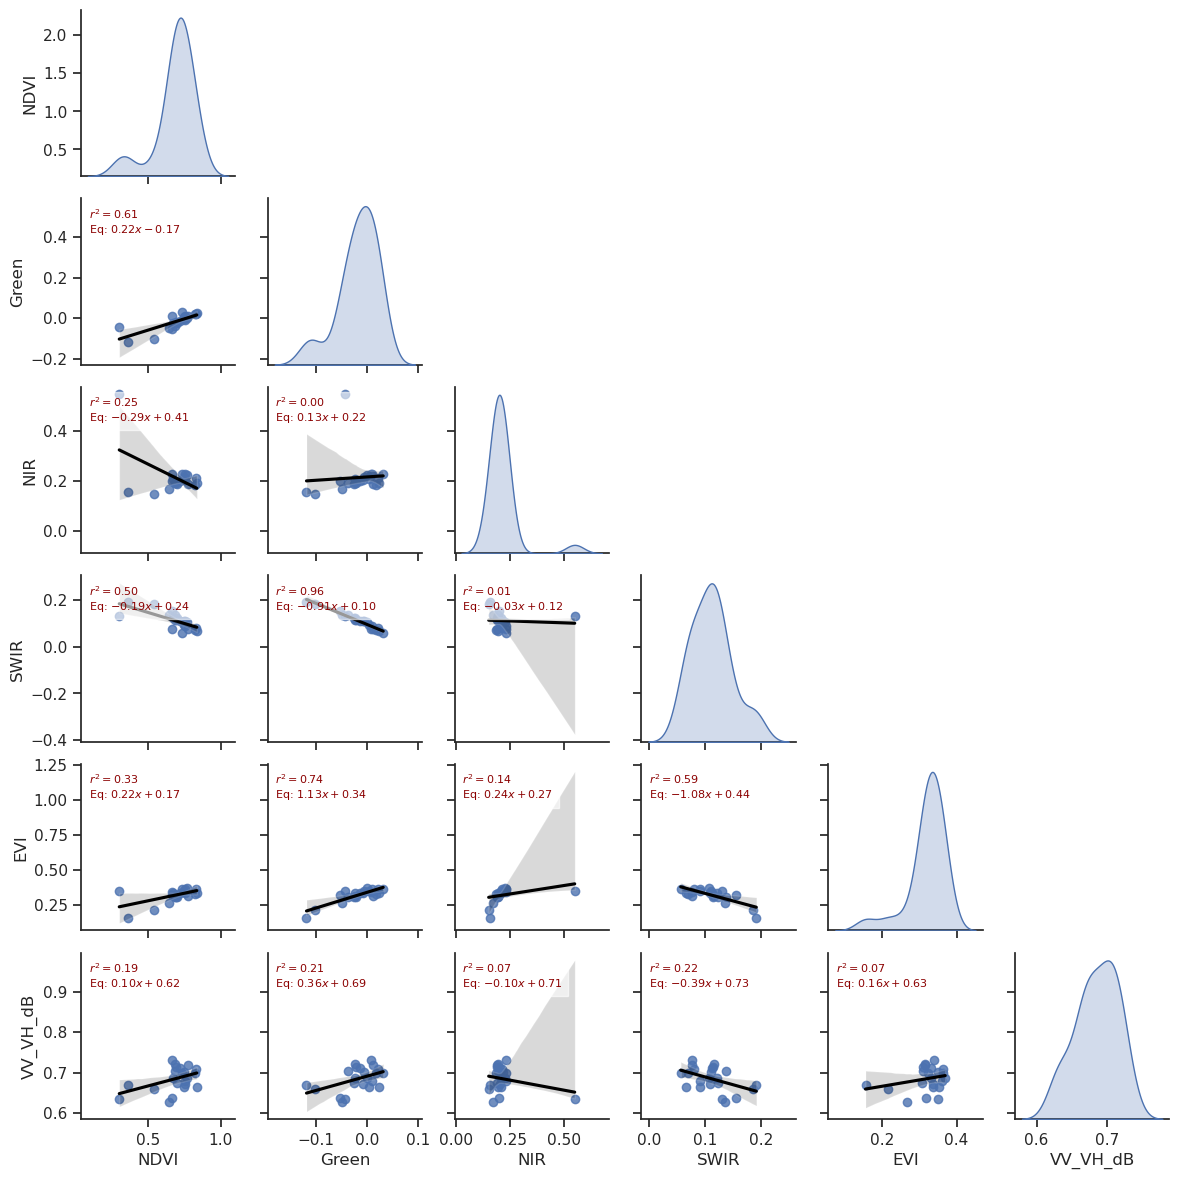

In [66]:
import seaborn as sns
from scipy.stats import linregress

def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')
    
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(S1cov_df, kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
plt.savefig(fname='S1_VV_VH_S2_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### Sensitivity Assessment of Correlation Between Bands B and Band A

first find what timesteps match between B and A, then we can plot those if there are enough..

In [140]:
#Develop a Data Frame of the matching capture dates ERROR DATES REMOVED '2016-10-9' and '2018-08-12'
time_subset = ['2016-01-31','2016-04-24','2016-07-17',
               '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
               '2017-12-03','2018-02-25','2018-05-20',
               '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
               '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
               '2021-02-21','2021-05-16']

time_subset_df = pd.DataFrame(time_subset)
time_subset_df.columns = ['time_subset']
time_subset_df['time_subset'] = pd.to_datetime(time_subset_df['time_subset'])

Appending corrected format 'time' to s2 metrics

In [141]:
EVI_df['time_'] = time
Green_df['time_'] = time
NDVI_df['time_'] = time
NIR_df['time_'] = time
SWIR_df['time_'] = time

In [142]:
#Making VH and VV subsets available for analysis
S1_VHSubset = pd.read_csv('S1_VH_dB_Alligned_S2_v2.csv')
S1_VHSubset.rename(columns={"DATES IN ALLIGNMENT":"Time_",},inplace=True)
S1_VHSubset.index = time_subset

#S1_VVSubset = pd.read_csv('S1_VV_dB_Alligned_S2.csv')
#S1_VVSubset.rename(columns={"DATES IN ALLIGNMENT":"Time_",},inplace=True)
#S1_VVSubset.index = time_subset

***OLD TIMES***
EVI_subset = EVI_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17','2016-10-09',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20','2018-08-12',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]

In [143]:
#Gathering subset of matching dates between S1(A) and S2(B)
NDVI_subset = NDVI_df[NDVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
EVI_subset = EVI_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
Green_subset = Green_df[Green_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
NIR_subset = NIR_df[NIR_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]
SWIR_subset = SWIR_df[EVI_df['time_'].isin(['2016-01-31','2016-04-24','2016-07-17',
                  '2017-01-01','2017-03-26','2017-06-18','2017-09-10',
                  '2017-12-03','2018-02-25','2018-05-20',
                  '2018-11-04','2019-01-27','2019-04-21','2019-07-14',
                  '2019-10-06','2019-12-29','2020-03-22','2020-11-29',
                  '2021-02-21','2021-05-16'])]

In [144]:
#Creating a DataFrame for a covariance matrix between S2 B band Indices

cov_s = NDVI_df['NDVI'] # 1 Creating a string of NDVI
cov_df = pd.DataFrame(cov_s) # 2 Converting to DataFrame

# 3 Joining subsets to DataFrame
TCG = Green_df['Green']
cov_df = cov_df.join(TCG)
NIR = NIR_df['NIR']
cov_df = cov_df.join(NIR)
SWIR = SWIR_df['SWIR']
cov_df = cov_df.join(SWIR)
EVI = EVI_df['EVI']
cov_df = cov_df.join(EVI)

In [145]:
#Creating a DataFrame for a covariance matrix between S1 and S2 Indices

S1cov_s = NDVI_subset['NDVI'] # 1 Creating a string of NDVI
S1cov_df = pd.DataFrame(S1cov_s) # 2 Converting to DataFrame

# 3 Joining subsets to DataFrame
TCG = Green_subset['Green']
S1cov_df = S1cov_df.join(TCG)
NIR = NIR_subset['NIR']/10000
S1cov_df = S1cov_df.join(NIR)
SWIR = SWIR_subset['SWIR']/10000
S1cov_df = S1cov_df.join(SWIR)
EVI = EVI_subset['EVI']
S1cov_df = S1cov_df.join(EVI)
S1cov_df.index = time_subset # 4 Assigning time as the index for the subset data
S1 = S1_VHSubset['VH_dB']
S1cov_df = S1cov_df.join(S1)
#S1 = S1_VVSubset['VV_dB']
#S1cov_df = S1cov_df.join(S1)

## Plotting covariance scatterplots for A and B band Subsets

/tmp/ipykernel_386/3398262174.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_S2_SENS_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_386/3398262174.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_S2_SENS_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',


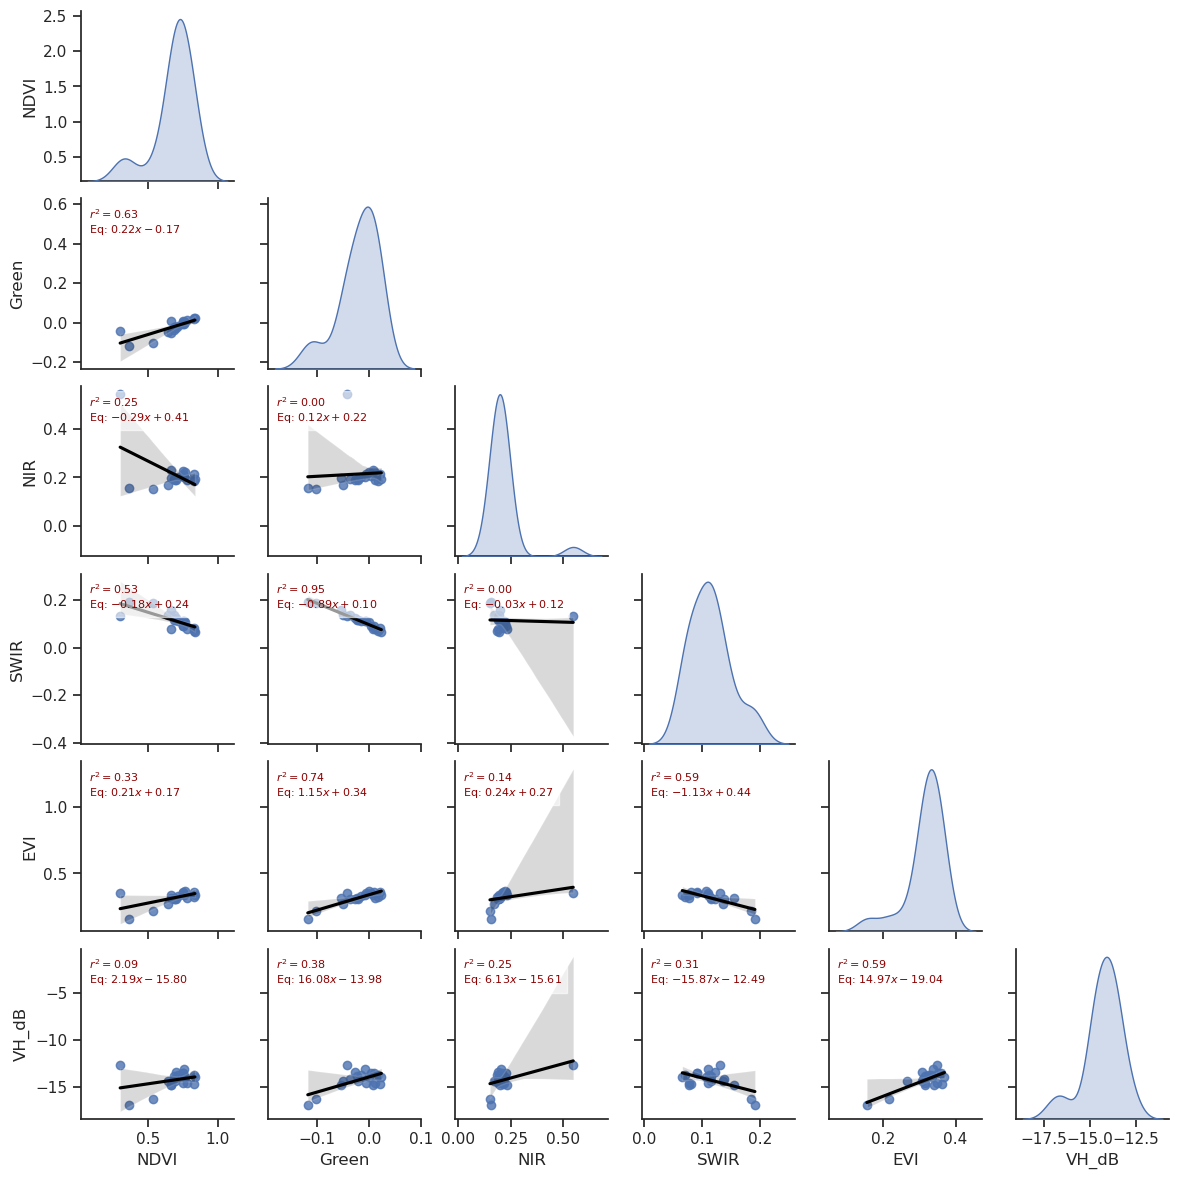

In [146]:
import seaborn as sns
from scipy.stats import linregress

def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')
    
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(S1cov_df, kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
plt.savefig(fname='S1_VH_S2_SENS_Corr_Plt.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

# VV/VH Correlation with S2